# Tunnel++

***Goal***: To make an improved version of [Location+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/) that incorporates pitch tunneling. <br>
**Author**: Jensen Holm <br>
**Date**: 2024

In [1]:
import statcast_pitches
import polars as pl
from plotnine import *
import plotly.express as px
import os

LOCAL_DATA_DIR = os.path.join("..", "data")

## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches) 

In [2]:
pitches_lf: pl.LazyFrame = statcast_pitches.load() # default is all pitches

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

print(f"N Pitches: {n_pitches}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 7011927
Date Range: 2015-04-05 - 2024-10-30


In [3]:
run_values_24 = pl.scan_csv(
    os.path.join(LOCAL_DATA_DIR, "run_values.csv"),
).rename({"event": "events"}) # it is called 'events' in pitches_df

## Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`| 
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **decision_distance** | 3D distance between pitches in a two pitch sequence at 0.12 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

Adding `delta_run_exp` first

In [4]:
from utils import description_replace_mapping


def add_pitch_run_value(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Takes in a dataframe of pitches, and adds 2024 run value to each one"""
    pitch_runs_lf = lf.join(
        other=run_values_24,
        on=["events", "balls", "strikes"],
        how="left",
    )

    mapped_des_pitches = pitch_runs_lf.with_columns([
        pl.col("description")
        .replace_strict(description_replace_mapping, default=None)
        .alias("play_des"),
    ])

    pitches_run_value_lf = mapped_des_pitches.join(
        other=run_values_24,
        right_on=["events", "balls", "strikes"],
        left_on=["play_des", "balls", "strikes"],
        how="left",
        suffix="_des",
    ).with_columns([
        pl.when(pl.col("delta_run_exp").is_null())
        .then(pl.col("delta_run_exp_des"))
        .otherwise(pl.col("delta_run_exp"))
        .alias("delta_run_exp"),
    ])
    return pitches_run_value_lf

pitches_run_value_lf = pitches_lf.pipe(add_pitch_run_value)
pitches_run_value_lf.select(
    "pitch_type",
    "description",
    "balls",
    "strikes",
    "delta_run_exp",
).describe()

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""6914851""","""7011927""",7.011927e6,7.011927e6,6.814457e6
"""null_count""","""97076""","""0""",0.0,0.0,197470.0
"""mean""",null,null,0.875591,0.888314,0.000005
"""std""",null,null,0.966838,0.827263,0.242352
"""min""","""AB""","""ball""",0.0,0.0,-1.661
"""25%""",null,null,0.0,0.0,-0.066
"""50%""",null,null,1.0,1.0,-0.017
"""75%""",null,null,1.0,2.0,0.036
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.702


Mirroring LHP metrics as if they were thrown by RHP

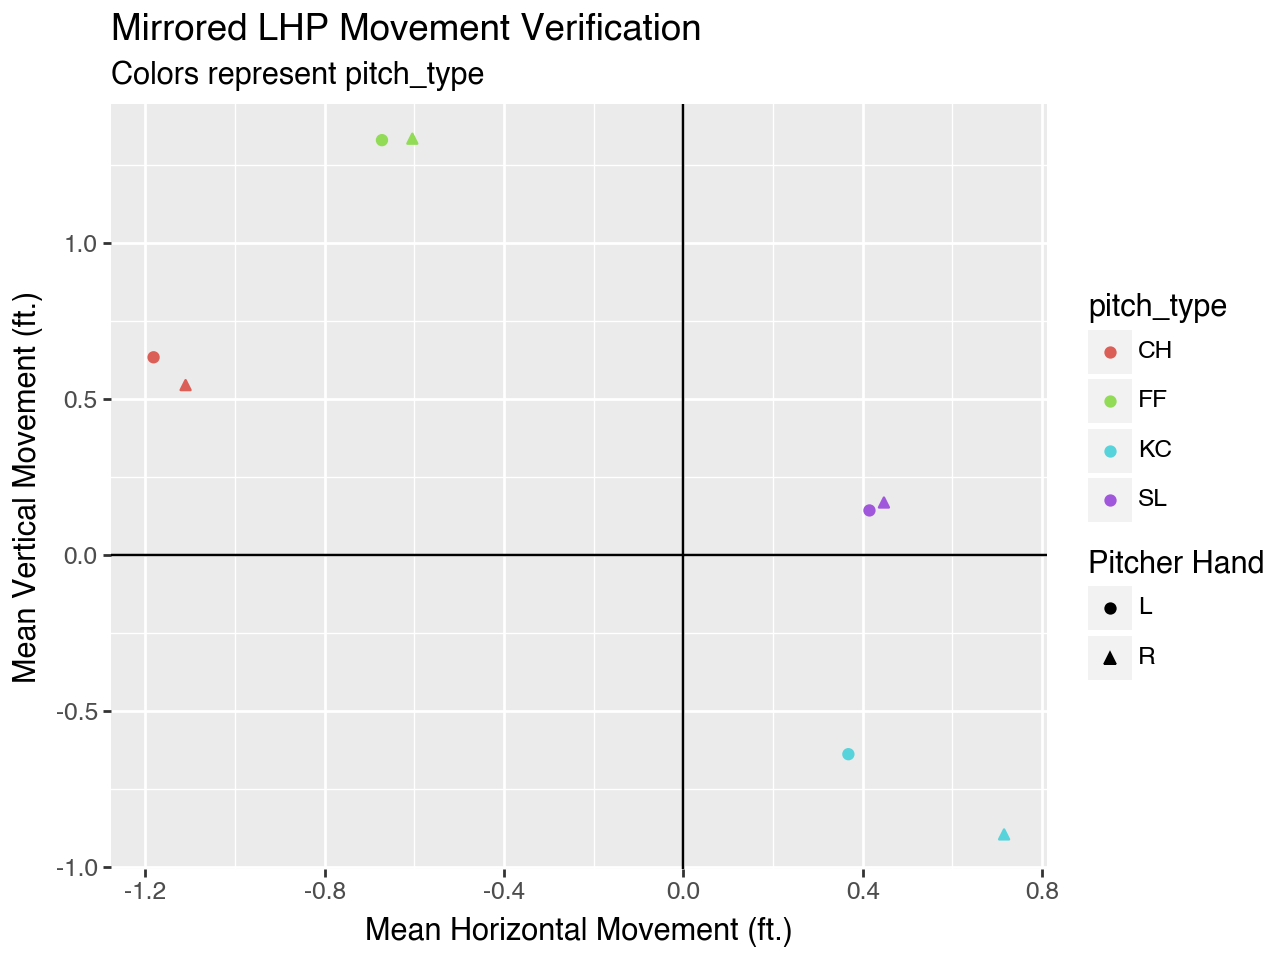

In [5]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),
    )

mirrored_pitches_lf = pitches_run_value_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").mean().alias("mean_pfx_x"),
            pl.col("pfx_z").mean().alias("mean_pfx_z"),
        ).collect(),
        aes(x="mean_pfx_x", y="mean_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="Mean Horizontal Movement (ft.)",
        y="Mean Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Displacement

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

Plugging in our pitch data into the kinematic equation for displacement below, I can solve for where the ball 

$d = v_{i} * t + \frac{1}{2} * a * t^{2}$

**where**:
- $t$ = time (seconds)
- $v_{i}$ = velocity at time $t$
- $a_{i}$ = acceleration at time $t$

**Steps**:

For a given time $t$ ...

1. Estimate how many feet the ball will travel in $t$ seconds (assuming acceleration = az)
2. Estimate the x and y positions of the ball at $t$ seconds (assuming acceleration = ax & ay) 

In [6]:

def calculate_ball_pos_at_t(lf: pl.LazyFrame, *ts) -> pl.LazyFrame:
    """Computes the x, y and z positions of a baseball at all the times in specified in ts"""
    return lf.with_columns([
        ((pl.col(f"v{dim}0") * t) + (1/2 * pl.col(f"a{dim}") * t**2)).alias(f"{dim}_{t:.3f}")
        for dim in ["x", "y", "z"] 
        for t in ts
    ])

# 0.12 is about the 'decision time' and 0.167 is about 'commit time'
ball_pos_lf = mirrored_pitches_lf.pipe(calculate_ball_pos_at_t, 0.12, 0.167)

(ball_pos_lf
    .select("x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167")
    .describe())

statistic,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167
str,f64,f64,f64,f64,f64,f64
"""count""",6.915173e6,6.915173e6,6.915173e6,6.915173e6,6.915173e6,6.915173e6
"""null_count""",96754.0,96754.0,96754.0,96754.0,96754.0,96754.0
"""mean""",0.263782,-15.325393,-0.64541,0.358194,-21.223518,-0.989773
"""std""",0.665031,1.029002,0.338838,0.90022,1.41939,0.455678
"""min""",-12.679482,-18.257279,-9.331836,-18.406781,-25.252687,-13.476103
"""25%""",-0.242082,-16.131178,-0.872586,-0.325748,-22.334216,-1.293961
"""50%""",0.456214,-15.523112,-0.658437,0.617835,-21.498054,-1.00518
"""75%""",0.744562,-14.614048,-0.432851,1.00844,-20.244422,-0.703514
"""max""",2.979625,-4.827299,2.960119,4.094582,-6.705236,3.95633


In [7]:

decision_time_fig = px.scatter_3d(ball_pos_lf
                                  .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
                                  .select("pitch_type", "x_0.120", "y_0.120", "z_0.120")
                                  .group_by("pitch_type")
                                  .agg(
                                      pl.col("x_0.120").mean().alias("mean_x_0.120"),
                                      pl.col("y_0.120").mean().alias("mean_y_0.120"),
                                      pl.col("z_0.120").mean().alias("mean_z_0.120")
                                )
                                .collect(),
                                y="mean_x_0.120",
                                z="mean_y_0.120",
                                x="mean_z_0.120",
                                color="pitch_type")

commit_time_fig = px.scatter_3d(ball_pos_lf
                                  .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
                                  .select("pitch_type", "x_0.167", "y_0.167", "z_0.167")
                                  .group_by("pitch_type")
                                  .agg(
                                      pl.col("x_0.167").mean().alias("mean_x_0.167"),
                                      pl.col("y_0.167").mean().alias("mean_y_0.167"),
                                      pl.col("z_0.167").mean().alias("mean_z_0.167")
                                      )
                                    .collect(),
                                y="mean_x_0.167",
                                z="mean_y_0.167",
                                x="mean_z_0.167",
                                color="pitch_type")

decision_time_fig.add_traces(commit_time_fig.data)
decision_time_fig.show()

In [8]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_plate_x",
    "prev_plate_z",
]

def two_pitch_sequences(lf: pl.LazyFrame) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=True,
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in sorted_lf.collect_schema().names()
        ])
        .select(*sort_cols + prev_features)
        .join(other=lf, on=sort_cols, how="right")
    )

def add_diff_features(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (pl.col("release_speed") - pl.col("prev_release_speed")).alias("velocity_diff"),
        (pl.col("effective_speed") - pl.col("prev_effective_speed")).alias("effective_speed_diff"),
        (pl.col("pfx_x") - pl.col("prev_pfx_x")).alias("pfx_diff"),
        (pl.col("pfx_z") - pl.col("prev_pfx_z")).alias("pfx_z_diff"),
        (((pl.col("plate_x") - pl.col("prev_plate_x") ** 2) + 
         (pl.col("plate_z") - pl.col("prev_plate_z") ** 2)) ** 0.5).alias("distance"),
         (pl.col("delta_run_exp") + pl.col("prev_delta_run_exp")).alias("seq_delta_run_exp")
    )


sequence_pitches_lf = (mirrored_pitches_lf
                       .pipe(two_pitch_sequences)
                       .pipe(add_diff_features))

(sequence_pitches_lf
    .select("seq_delta_run_exp", "distance", *[f for f in sequence_pitches_lf.collect_schema().names() if f.endswith("_diff")])
    .describe())

statistic,seq_delta_run_exp,distance,velocity_diff,effective_speed_diff,pfx_diff,pfx_z_diff
str,f64,f64,f64,f64,f64,f64
"""count""",6.652947e6,6.760267e6,6.761304e6,6.7085e6,6.760124e6,6.760141e6
"""null_count""",371764.0,264444.0,263407.0,316211.0,264587.0,264570.0
"""mean""",-0.001088,NaN,-0.004767,-0.000022,0.000115,-0.001595
"""std""",0.335829,NaN,7.284445,7.506979,0.996743,0.958519
"""min""",-2.166,0.0,-58.0,-98.3,-4.57,-4.29
"""25%""",-0.154,NaN,-3.9,-4.0,-0.46,-0.43
"""50%""",-0.022,NaN,0.0,0.0,0.0,0.0
"""75%""",0.054,NaN,3.9,3.9,0.47,0.43
"""max""",6.561,3.784997,60.6,113.9,4.49,5.36
